<a href="https://colab.research.google.com/github/jiahao20geng/PHAS0102/blob/main/PHAS0102_class3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-f0e75278-a68d-fd59-b6ab-c52aa69b3ae5
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:
import numpy as np
import numba

sigma = .1

@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

In [ ]:
npoints = 400
nsources = 50

plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)

# We are picking random sources

sources = rand.rand(nsources, 3)

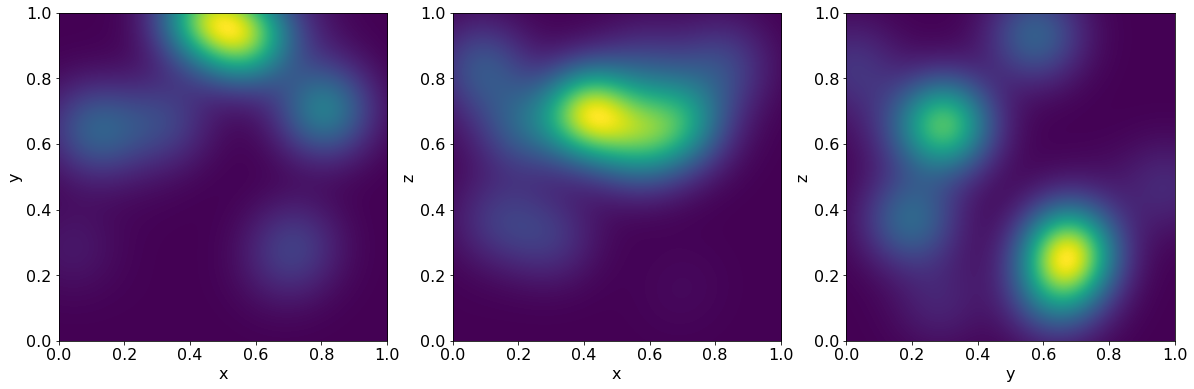

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.size"] = 16 #字体大小

result = np.zeros(len(targets), dtype=np.float64) #返回来一个给定形状和类型的用0填充的数组

weights = rand.rand(len(sources))

rbf_evaluation(sources, targets, weights, result)

def visualize(result, npoints):
    """A helper function for visualization"""
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T#是一个npointspoints*npoints的矩阵
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   #把画布分为1*3，这是1号区
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1],origin='lower')#imshow为制作热力图
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')

    
    
visualize(result, npoints)

In [ ]:
import numba
from numba import cuda
import math


SX = 16
SY = nsources



@cuda.jit
def rbf_evaluation_cuda(sources, targets, weights, result):
    local_result = cuda.shared.array((SX, nsources), numba.float32)
    local_targets = cuda.shared.array((SX, 3), numba.float32)
    local_sources = cuda.shared.array((SY, 3), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
    
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[ty]
        
    # Let us now sync all threads
    
    cuda.syncthreads()
    
    # Now compute the interactions
    
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    
    if ty == 0:
        res = numba.float32(0)
        for index in range(nsources):
            res += local_result[tx, index]
        result[px] = res    

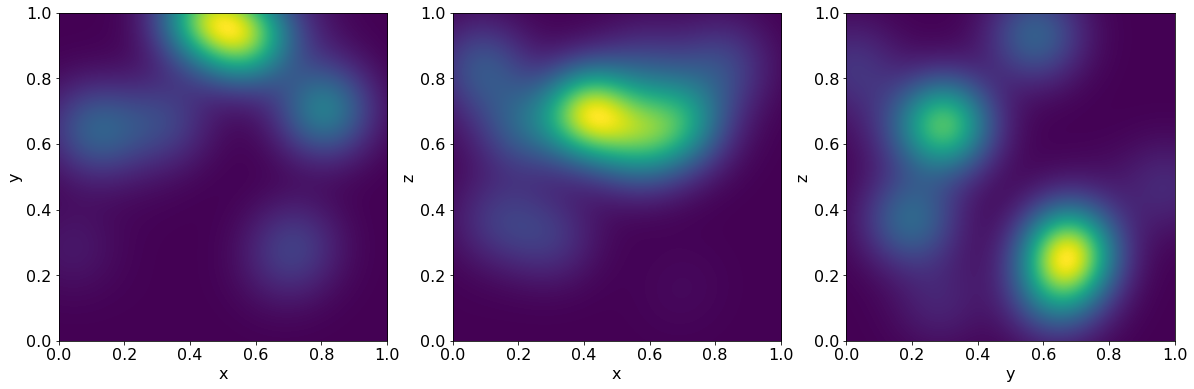

In [ ]:
nblocks = (targets.shape[0] + SX - 1) // SX
result = np.zeros(len(targets), dtype=np.float32)
rbf_evaluation_cuda[(nblocks, 1), (SX, SY)](sources.astype('float32'), targets.astype('float32'), weights.astype('float32'), result)

visualize(result, npoints)

In [ ]:
%timeit rbf_evaluation_cuda[(nblocks, 1), (SX, SY)](sources.astype('float32'), targets.astype('float32'), weights.astype('float32'), result)
%timeit rbf_evaluation(sources, targets, weights, result)

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


8.79 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
663 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import numpy as np
a=[1,2,3]
b=[4,5,6]
a=[[1],[2],[3]]
b=[[1],[2],[3]]

print(np.vstack((a,b)))#vstack是垂直的把数组给堆叠起来

[[1]
 [2]
 [3]
 [1]
 [2]
 [3]]


In [ ]:
import numpy as np
a=[[1,2,3],
   [4,5,6]]
print("列表a如下：")
print(a)

print("增加一维，新维度的下标为0")
c=np.stack(a,axis=0)
print(c)

print("增加一维，新维度的下标为1")
c=np.stack(a,axis=1)
print(c)


列表a如下：
[[1, 2, 3], [4, 5, 6]]
增加一维，新维度的下标为0
[[1 2 3]
 [4 5 6]]
增加一维，新维度的下标为1
[[1 4]
 [2 5]
 [3 6]]
